In [162]:
import librosa
import librosa.display
%pylab inline --no-import-all
from scikits.audiolab import wavread
from scipy import signal
import matplotlib.pyplot as plt
from scipy.io import wavfile
import math
import numpy as np
from numpy.fft import fft
import pylab
import mir_eval
import seaborn
seaborn.set(style="ticks")

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [163]:
def loadsingal(filename):
    signal ,sample_rate=librosa.load(filename,sr=12000, mono=True)
    signal=signal#[int(2.5 * sample_rate):int(3.0 * sample_rate)] 
    return signal ,sample_rate

In [164]:
def pad_audio(data, fs, T):
    # Calculate target number of samples
    N_tar = int(fs * T)
    # Calculate number of zero samples to append
    shape = data.shape
    # Create the target shape    
    N_pad = N_tar - shape[0]
    #print("Padding with %s seconds of silence" % str(N_pad/fs) )
    shape = (N_pad,) + shape[1:]
    # Stack only if there is something to append    
    if shape[0] > 0:                
        if len(shape) > 1:
            return np.vstack((np.zeros(shape),
                              data))
        else:
            return np.hstack((np.zeros(shape),
                              data))
    else:
        return data

In [165]:
len(signals)
signals[0].shape

(120001,)

In [166]:
from scipy import signal
def spectrogram(signals,plot=False,sample_rate=12000):
    #Sxxs=np.empty((0,0))
    Sxxs=[]
    for i,data in enumerate(signals):
        f, t, Sxx = signal.spectrogram(data,sample_rate)
        #if i==0:
        #    Sxxs=Sxx
        #else:
        #    Sxxs=np.append(Sxxs, Sxx, axis=0)
        Sxxs.append(Sxx)
       
        if plot==True:
            plt.pcolormesh(t, f, Sxx)
            plt.ylabel('Frequency [Hz]')
            plt.xlabel('Time [sec]')
            plt.grid()
            plt.show()
    return Sxxs

In [191]:
import glob, os
dir ="/Users/kimtaing/Documents/github/MLBD/MLBD/birdsong/"
os.chdir(dir+"BECASSE FILTREe")
filenames=[]
for file in glob.glob("*.wav"):
    filenames.append('/BECASSE FILTREe/'+file)

os.chdir(dir+"NON-BECASSE-FILTREE")

filenames_N=[]
for file in glob.glob("*.wav"):
    filenames_N.append('NON-BECASSE-FILTREE/'+file)

print filenames[:3]
print filenames_N[:3]

n=20
filenames=filenames[:n]
filenames_N=filenames_N[:n]
signals=[]
signals_N=[]
time=float(30)

for filename in filenames:
    path=dir +filename
    s ,sample_rate=loadsingal(path)
    s_t=pad_audio(s,sample_rate,time)
    signals.append(s_t)

for filename in filenames_N:
    path=dir +filename
    s_N ,sample_rate_N=loadsingal(path)
    s_N_t=pad_audio(s_N,sample_rate_N,time)
    signals_N.append(s_N_t)
    
    
X_train_B=np.asarray(spectrogram(signals,False,sample_rate))
y_train_B=np.ones(len(X_train_B))  # 1:becasse, o: non becasse

X_train_N=np.asarray(spectrogram(signals_N,False,sample_rate))
y_train_N=np.zeros(len(X_train_N))  # 1:becasse, o: non becasse

X_train = np.concatenate((X_train_B, X_train_N),axis=0)
y_train = np.concatenate((y_train_B ,y_train_N),axis=0)

X_test = X_train
y_test = y_train

print len(X_train)
print len(y_train)
print X_train.shape
print y_train.shape

['/BECASSE FILTREe/10f1-EQ37B-01.wav', '/BECASSE FILTREe/10f100-EQ37B-01.wav', '/BECASSE FILTREe/10f101-EQ37B-01.wav']
['NON-BECASSE-FILTREE/a1011-EQ37B-01.wav', 'NON-BECASSE-FILTREE/a1019-EQ37B-01.wav', 'NON-BECASSE-FILTREE/a1090-EQ37B-01.wav']
40
40
(40, 129, 1607)
(40,)


In [192]:
import numpy as np
from matplotlib import pyplot as pl

from keras.datasets import mnist
from keras.models import Model
from keras.layers.core import Dense, Dropout, Flatten
from keras.optimizers import RMSprop
from keras.utils import np_utils
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Input
from sklearn import metrics as me
from scipy import stats

%matplotlib inline

In [193]:
n_train, height, width = X_train.shape
n_test, _, _ = X_test.shape
print X_train.shape
print y_train.shape
X_train = X_train.reshape(n_train, 1, height, width).astype('float32')
X_test = X_test.reshape(n_test, 1, height, width).astype('float32')

maxi_train_value=np.max(X_train[2])
maxi_test_value=np.max(X_test[2])


X_train /= float(maxi_train_value)
X_test /= float(maxi_test_value)

n_classes = 2

print n_train, 'train samples'
print n_test, 'test samples'

print X_train.shape
print y_train.shape
# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)

(40, 129, 1607)
(40,)
40 train samples
40 test samples
(40, 1, 129, 1607)
(40,)


In [194]:
l0 = Input(shape=(1, height, width), name='l0')

l1 = Convolution2D(9, 5, 5, border_mode='same', activation='relu', name='l1')(l0)
l1_mp = MaxPooling2D(pool_size=(2, 2), name='l1_mp')(l1)

l2 = Convolution2D(9, 5, 5, border_mode='same', activation='relu', name='l2')(l1_mp)
l2_mp = MaxPooling2D(pool_size=(2, 2), name='l2_mp')(l2)

l3 = Convolution2D(16, 3, 3, border_mode='same', activation='relu', name='l3')(l2_mp)
l3_mp = MaxPooling2D(pool_size=(2, 2), name='l3_mp')(l3)

flat = Flatten(name='flat')(l3_mp)

l4 = Dense(25, activation='relu', name='l4')(flat)

l5 = Dense(n_classes, activation='softmax', name='l5')(l4)

model = Model(input=l0, output=l5)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
l0 (InputLayer)                  (None, 1, 129, 1607)  0                                            
____________________________________________________________________________________________________
l1 (Convolution2D)               (None, 9, 129, 1607)  234         l0[0][0]                         
____________________________________________________________________________________________________
l1_mp (MaxPooling2D)             (None, 9, 64, 803)    0           l1[0][0]                         
____________________________________________________________________________________________________
l2 (Convolution2D)               (None, 9, 64, 803)    2034        l1_mp[0][0]                      
___________________________________________________________________________________________

In [195]:
print X_train.shape
print Y_train.shape

print X_test.shape
print Y_test.shape


(40, 1, 129, 1607)
(40, 2)
(40, 1, 129, 1607)
(40, 2)


In [196]:
batch_size = 128
n_epoch = 10

model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])
history = model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=n_epoch, verbose=1, validation_data=(X_test, Y_test))

Train on 40 samples, validate on 40 samples
Epoch 1/10
40/40 [==============================] - 30s - loss: 0.6938 - acc: 0.4750 - val_loss: 0.6086 - val_acc: 0.9750
Epoch 2/10
40/40 [==============================] - 29s - loss: 0.6086 - acc: 0.9750 - val_loss: 0.4088 - val_acc: 0.9250
Epoch 3/10
40/40 [==============================] - 29s - loss: 0.4088 - acc: 0.9250 - val_loss: 0.7435 - val_acc: 0.6250
Epoch 4/10
40/40 [==============================] - 31s - loss: 0.7435 - acc: 0.6250 - val_loss: 0.5725 - val_acc: 0.6500
Epoch 5/10
40/40 [==============================] - 31s - loss: 0.5725 - acc: 0.6500 - val_loss: 0.2122 - val_acc: 0.9500
Epoch 6/10
40/40 [==============================] - 29s - loss: 0.2122 - acc: 0.9500 - val_loss: 0.1667 - val_acc: 0.9500
Epoch 7/10
40/40 [==============================] - 27s - loss: 0.1667 - acc: 0.9500 - val_loss: 0.1455 - val_acc: 0.9500
Epoch 8/10
40/40 [==============================] - 27s - loss: 0.1455 - acc: 0.9500 - val_loss: 0.124

('Test score:', 0.1030004195868969)
('Test accuracy:', 0.94999999999999996)


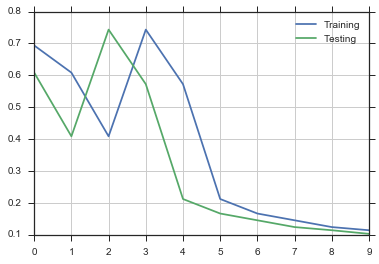

In [197]:
pl.plot(history.history['loss'], label='Training')
pl.plot(history.history['val_loss'], label='Testing')
pl.legend()
pl.grid()

score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

In [198]:
pred = model.predict_on_batch(X_test)
pred = np_utils.probas_to_classes(pred)
me.confusion_matrix(y_test, pred)

array([[18,  2],
       [ 0, 20]])